In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from safety_train_new import Extractor, Adaptor, Classifier, FullModel

from glob import glob
from PIL import Image
import torchvision.transforms as transforms
from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


In [25]:
root_path = "/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/no_LLM_ViT_20241223/lr_1e-06_visual_feature_extractor_ViT_LLM_loaded_False/"
model_path = glob(f"{root_path}*.pt")[0]

parameters_path = glob(f"{root_path}*.csv")[0]
parameters = pd.read_csv(parameters_path)
parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
parameters = parameters.iloc[0].to_dict()


In [57]:
def model_test(model, test_loader, LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_outputs = []
    all_labels = []
    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, target in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            data, target = data.cuda(), target.cuda().long()
            output = model(data)['features']
            all_outputs.append(output)
            all_labels.append(target)
            
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_outputs, all_labels

In [58]:
data = pd.read_csv(parameters['placepulse_datapath'])
data_ls = data[data['label'] != 0]
data_ls.loc[data_ls[data_ls['label'] == -1].index, 'label'] = 0
transform = get_transforms((224,224))
train_num = int(len(data_ls) * 0.6)
valid_num = int(len(data_ls) * 0.2)


LLM_pre_extractor = None
train_dataset = SafetyPerceptionDataset(data_ls[:train_num], transform=transform, paras=parameters)
valid_dataset = SafetyPerceptionDataset(data_ls[train_num:train_num+valid_num], transform=transform, paras=parameters)
test_dataset = SafetyPerceptionDataset(data_ls[train_num+valid_num:], transform=transform, paras=parameters)
    
    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=parameters['batch_size'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=parameters['batch_size'])
extractor = Extractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
adaptor = Adaptor(input_dim=parameters['input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
classifier = Classifier(input_dim=parameters['adaptor_output_dim'], num_classes=parameters['num_classes']) # [128, 2]
model = FullModel(extractor, adaptor, classifier).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load(model_path), strict=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
valid_data = []
valid_labels = []

for data, labels in valid_loader:
    valid_data.append(data)
    valid_labels.append(labels)

valid_data = torch.cat(valid_data, dim=0)
valid_labels = torch.cat(valid_labels, dim=0)

print(valid_data.shape)
print(valid_labels.shape)

In [80]:
nodes, _ = get_graph_node_names(model)
# print(nodes)
feature_extracter = create_feature_extractor(model, return_nodes={'adaptor.layer_norm': 'features'})
all_outputs, all_labels = model_test(feature_extracter, train_loader)
valid_outputs, valid_labels = model_test(feature_extracter, valid_loader)

all_outputs, all_labels = all_outputs.cpu().numpy(), all_labels.cpu().numpy()
valid_outputs, valid_labels = valid_outputs.cpu().numpy(), valid_labels.cpu().numpy()

100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 创建随机森林分类器
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 训练模型
rf_classifier.fit(all_outputs, all_labels)

# 预测
predictions = rf_classifier.predict(valid_outputs)

# 计算准确率
accuracy = accuracy_score(valid_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# 打印分类报告
print(classification_report(valid_labels, predictions))

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       884
           1       0.65      0.65      0.65       869

    accuracy                           0.66      1753
   macro avg       0.66      0.66      0.66      1753
weighted avg       0.66      0.66      0.66      1753



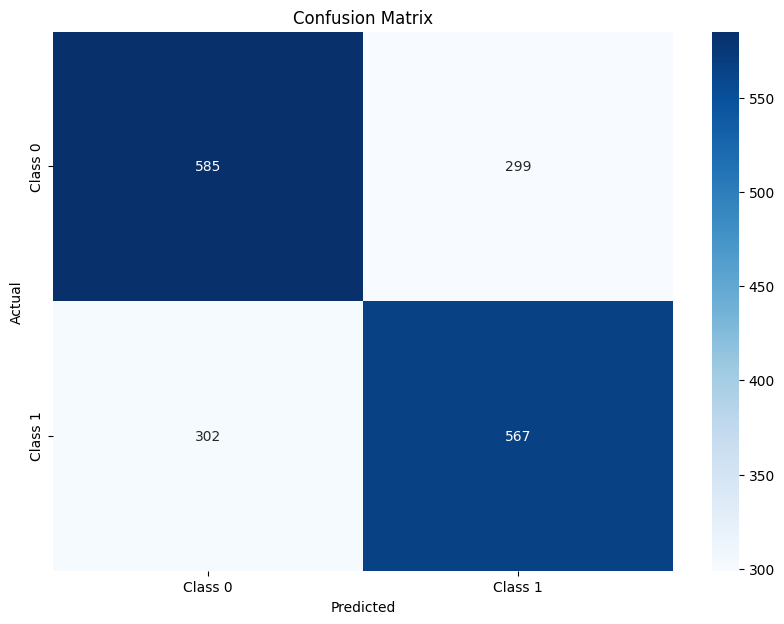

In [82]:
# 计算混淆矩阵
cm = confusion_matrix(valid_labels, predictions)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

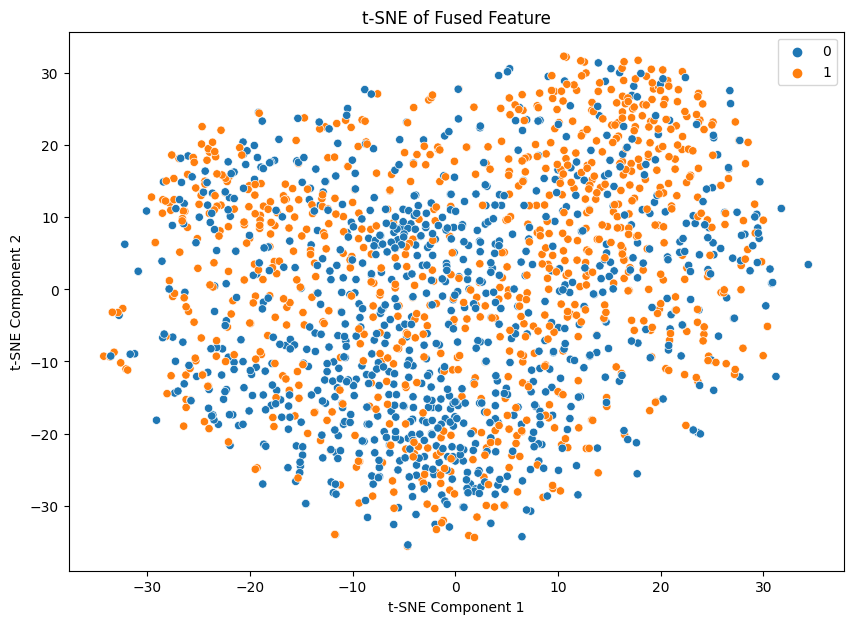

In [85]:
from sklearn.manifold import TSNE

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(valid_outputs)

# 绘制 t-SNE 结果
plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=valid_labels)
plt.title("t-SNE of Fused Feature")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Text(0.5, 1.0, 'PCA of Fused Feature')

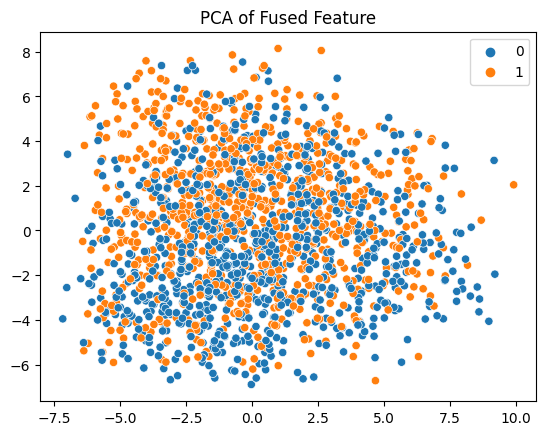

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
combined_feature_pca = pca.fit_transform(valid_outputs)

sns.scatterplot(x=combined_feature_pca[:,0], y=combined_feature_pca[:,1], hue=valid_labels)
plt.title("PCA of Fused Feature")

In [ ]:
# 使用shap计算每个维度的贡献
import shap

# 使用训练数据创建一个 SHAP explainer
explainer = shap.Explainer(mlp_classifier, X_train)
# explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_valid)

shap_values_overall = shap_values[0] + shap_values[1]
shap_values_sum = shap_values_overall.sum(axis=0).reshape(-1, 1)
print(f"image contribution: {shap_values_sum[:256].sum() / shap_values_sum.sum():.02%}, text contribution: {shap_values_sum[256:].sum() / shap_values_sum.sum():.02%}")

# 绘制 SHAP summary plot
# shap.summary_plot(shap_values, X_valid, feature_names=[f'Feature {i}' for i in range(X_valid.shape[1])])

In [ ]:


# # Example usage
# image_encoder = ImageEncoder(cfg_paras)
# text_encoder = TextEncoder(cfg_paras)
# fusion_model = AttentionalFeatureFusion(image_dim=cfg_paras['image_embedding'], text_dim=cfg_paras['text_embedding'], projection_dim=cfg_paras['projection_dim'])

# # Assuming we have image and text inputs
# image_input = torch.randn(1, 3, 112, 112).to(cfg_paras['device'])
# text_input_ids = torch.tensor([[101, 2054, 2003, 1996, 2171, 102]]).to(cfg_paras['device'])
# text_attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]]).to(cfg_paras['device'])

# image_features = image_encoder(image_input)
# text_features = text_encoder(text_input_ids, text_attention_mask)

# fused_features = fusion_model(image_features, text_features)
# print(fused_features)